# Siamese Network

## Importing the libraries and dependencies and drive
The following cell block imports all the libraries, functions, methods that are being used inn this jupyter notebook.<br>
The Deep Learning/Machine Learning Libarary being used here is the high level keras API of tensorflow 2.X.<Br>
And the plotting is done with matplotlib or seaborn plotting packages.

Along with this all the constants that will be common throughout the file are defined and declared here.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import random, math, os, pickle, random, librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from itertools import combinations
%matplotlib inline

EPOCHS = 200
BATCH_SIZE = 128
IMG_SIZE = (28,28)
SEED = 100
CLASSES = 10
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98

## Siamese network

Load Training and Testing Data.

data is made up of various audio files

In [4]:
with open('/content/drive/MyDrive/data/h4_trs.pkl', 'rb') as train_file:
    train_data = pickle.load(train_file)
print(train_data.shape)

with open('/content/drive/MyDrive/data/h4_tes.pkl', 'rb') as test_file:
    test_data = pickle.load(test_file)
print(test_data.shape)

(500, 16180)
(200, 22631)


### Create Positive pairs

In [18]:
def create_positive_pairs(one_speaker, L=45):
    batch = []
    pairs = list(combinations(range(len(one_speaker)), 2))
    one_pairs = random.sample(pairs, L)
    for a,b in one_pairs:
        a1 = np.zeros((45, 513))
        b1 = np.zeros((45, 513))
        stft_1 = np.abs(librosa.stft(one_speaker[a], n_fft=1024, hop_length=512)).T
        a1[:stft_1.shape[0]] = stft_1
        stft_2 = np.abs(librosa.stft(one_speaker[b], n_fft=1024, hop_length=512)).T
        b1[:stft_2.shape[0]] = stft_2
        batch.append([a1, b1])
    return batch

pos_batch = create_positive_pairs(train_data[10:20])
len(pos_batch)

45

### Create Negative pairs

In [19]:
def create_negative_pairs(speaker_num, data, L=45):
    batch = []
    
    start = speaker_num*10
    end = start + 10     
    speaker = random.choices(data[start: end], k=L)

    neg = np.concatenate((data[:start], data[end:]))
    not_speaker = random.choices(neg, k=L)

    for speaker, not_speaker in zip(speaker, not_speaker):
        x = np.abs(librosa.stft(speaker, n_fft=1024, hop_length=512)).T
        stft_pos = np.zeros((45, 513))
        stft_pos[:x.shape[0]] = x
        y = np.abs(librosa.stft(not_speaker, n_fft=1024, hop_length=512)).T
        stft_neg = np.zeros((45, 513))
        stft_neg[:y.shape[0]] = y
        batch.append([stft_pos, stft_neg])

    return batch

neg_batch = create_negative_pairs(5, train_data)
len(neg_batch)

45

### Create training data

In [20]:
batched_data = []
labels = []

for i in range(50):
    pos_batch = create_positive_pairs(train_data[i*10:i*10+10])
    pos_labels = list(np.ones((len(pos_batch))))

    neg_batch = create_negative_pairs(i, train_data)
    neg_labels = list(np.zeros((len(neg_batch))))
    
    batched_data += pos_batch + neg_batch
    labels += pos_labels + neg_labels

df_train = np.stack(batched_data)
labels = np.stack(labels)
df_train.shape, labels.shape

((4500, 2, 45, 513), (4500,))

### Create Testing/Validation data

In [21]:
test_data_batched = []
test_labels = []

for i in range(20):
    pos_batch = create_positive_pairs(test_data[i*10:i*10+10])
    pos_labels = list(np.ones((len(pos_batch))))

    neg_batch = create_negative_pairs(i, test_data)
    neg_labels = list(np.zeros((len(neg_batch))))
    
    test_data_batched += pos_batch + neg_batch
    test_labels += pos_labels + neg_labels

df_test = np.stack(test_data_batched)
test_labels = np.stack(test_labels)
df_test.shape, test_labels.shape

((1800, 2, 45, 513), (1800,))

### Model Architecture & Summary

In [48]:
def Siamese_model(shape = (45, 513)):
    inp1 = tf.keras.Input(shape=shape)
    inp2 = tf.keras.Input(shape=shape)

    model = tf.keras.Sequential([
                                tf.keras.Input(shape=shape),
                                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(513, return_sequences=True)),
                                # tf.keras.layers.LSTM(513, return_sequences=True),
                                tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.LSTM(513, return_sequences=True),
                                #  tf.keras.layers.BatchNormalization(),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(256, activation = 'relu'),
                                tf.keras.layers.Dense(64, activation = 'relu'),
                                #  tf.keras.layers.Lambda(lambda x: tf.where(x > 0.5, 1, 0))
    ])

    featsA = model(inp1)
    featsB = model(inp2)

    prediction = tf.reduce_sum(tf.multiply(featsA, featsB), axis = 1)

    # distance = tf.keras.layers.Concatenate()([featsA, featsB])
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(prediction)

    return tf.keras.models.Model(inputs=[inp1, inp2], outputs=outputs)

model = Siamese_model()
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 45, 513)]    0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 45, 513)]    0           []                               
                                                                                                  
 sequential_13 (Sequential)     (None, 45, 64)       7527024     ['input_34[0][0]',               
                                                                  'input_35[0][0]']               
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 45, 64)      0           ['sequential_13[0][0]',   

### Training

In [50]:
model.fit([df_train[:, 0], df_train[:, 1]], labels, 
          validation_data=([df_test[:,0], df_test[:,1]], test_labels), 
          batch_size=64, epochs=100)

Epoch 1/100
71/71 [==============================] - 18s 134ms/step - loss: 1.1913 - accuracy: 0.5547 - val_loss: 0.6800 - val_accuracy: 0.5644
Epoch 2/100
71/71 [==============================] - 7s 102ms/step - loss: 0.6079 - accuracy: 0.6698 - val_loss: 0.7593 - val_accuracy: 0.6200
Epoch 3/100
71/71 [==============================] - 7s 103ms/step - loss: 0.5211 - accuracy: 0.7367 - val_loss: 0.6133 - val_accuracy: 0.7117
Epoch 4/100
71/71 [==============================] - 7s 103ms/step - loss: 0.3978 - accuracy: 0.8176 - val_loss: 0.5869 - val_accuracy: 0.7606
Epoch 5/100
71/71 [==============================] - 7s 103ms/step - loss: 0.3371 - accuracy: 0.8513 - val_loss: 0.5391 - val_accuracy: 0.7306
Epoch 6/100
71/71 [==============================] - 7s 103ms/step - loss: 0.2558 - accuracy: 0.8980 - val_loss: 0.6645 - val_accuracy: 0.7394
Epoch 7/100
71/71 [==============================] - 7s 103ms/step - loss: 0.2151 - accuracy: 0.9164 - val_loss: 0.7546 - val_accuracy: 0.656

### Plot the results
Note:- Please ignore the X-label of the graphs. Its supposed to be "Epochs" but since the time is less - I labeled it D previously and am not able to run the whole model again due to shortage of time.

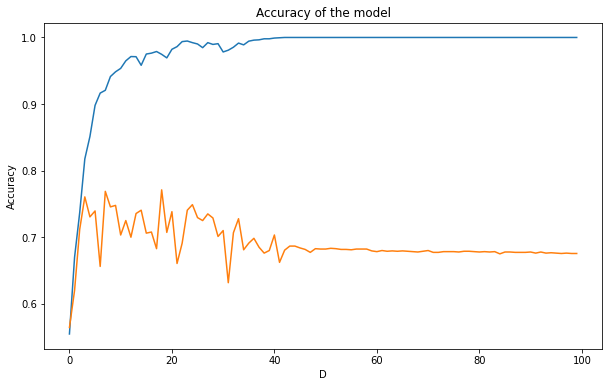

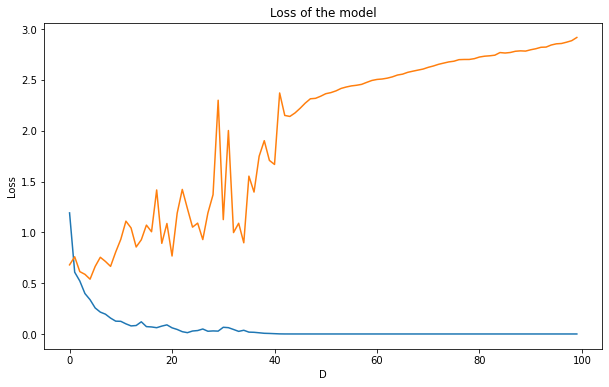

In [51]:
plt.figure(figsize = (10,6))
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])
plt.title("Accuracy of the model")
plt.xlabel('D')
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize = (10,6))
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Loss of the model")
plt.xlabel('D')
plt.ylabel("Loss")
plt.show()

### Conclusion
As it can be seen form the above that its quite evident that the model is over fitting to the training data. So the optimal choice of the epoch would be 20-30.

In [52]:
model.evaluate([df_test[:, 0], df_test[:, 1]] ,test_labels)

57/57 [==============================] - 1s 25ms/step - loss: 2.9171 - accuracy: 0.6756


[2.917083501815796, 0.6755555272102356]

In [ ]:
preds = model.predict([df_test[:, 0], df_test[:, 1]])
preds.shape

(1800, 45, 1)

In [ ]:
df_test.shape

(1800, 2, 45, 513)